In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

image shape: (1440, 1920, 3)
features shape: torch.Size([512, 360, 480])


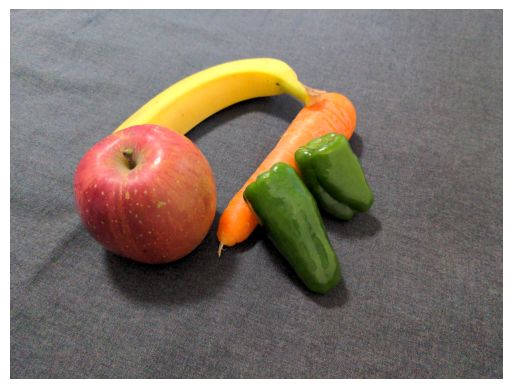

In [2]:
# show image
image = cv2.imread('../data/dff/sample_dataset/images/IMG_20220408_142309.png', cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)
# load LSeg tensor
features = torch.load('../data/dff/sample_dataset/rgb_feature_langseg/IMG_20220408_142309_fmap_CxHxW.pt')
print('image shape:', image.shape)
print('features shape:', features.shape)

In [3]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "../segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())

22
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


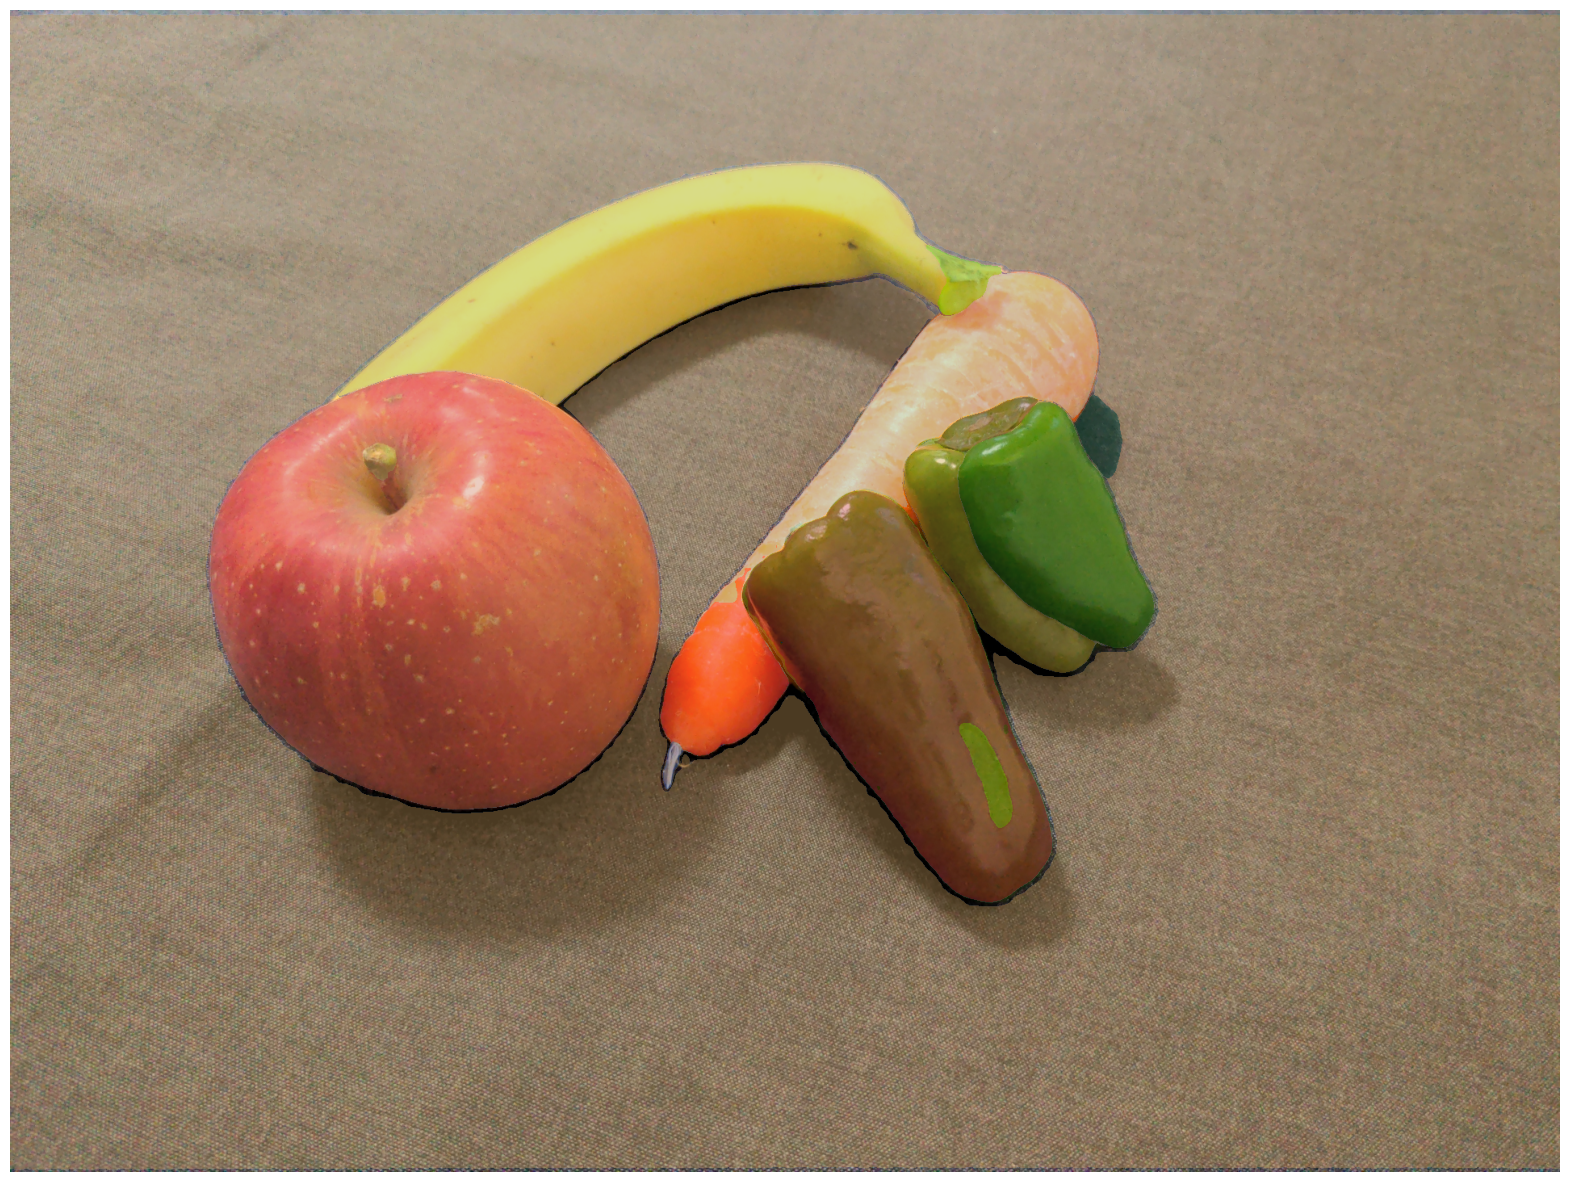

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [9]:
from segment_anything import SamPredictor
predictor = SamPredictor(sam)

In [18]:
predictor.set_image(image)
features: torch.Tensor = predictor.features # type: ignore
print(features.shape)

torch.Size([1, 256, 64, 64])


In [20]:
print(features.min(), features.max())

tensor(-0.8097, device='cuda:0') tensor(0.6183, device='cuda:0')


In [26]:
# PCA on features
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(features.reshape(features[1:].shape[0], -1).cpu().numpy())
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_.shape)


RuntimeError: shape '[0, -1]' is invalid for input of size 1048576